# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import json
import pprint
pp = pprint.PrettyPrinter()
import geopandas as gpd
from shapely.geometry import Point
import fiona
import time

# Scraiping

In [ ]:
url = "https://sfbay.craigslist.org/search/apa?s=0"
result = requests.get(url)
c = result.content
soup = BeautifulSoup(c, "lxml")

In [ ]:
# get number of total pages
total_page = soup.find("span",{"class":"totalcount"})
total_page = int(str(total_page).split(">")[1].split("<")[0])
total_page

In [ ]:
# make list of page URLS
page_urls = []

for i in range(round(total_page/120)):
    page_url = "https://sfbay.craigslist.org/search/apa?s=" + str(i*120)
    page_urls.append(page_url)

page_urls

In [ ]:
# make list of housing URLs

house_urls = []

for page_url in page_urls:

    result = requests.get(page_url)
    c = result.content
    soup = BeautifulSoup(c, "lxml")
    house = soup.find("ul",{'class':'rows'})
    house_urls_a = house.find_all("a",{"class":"result-title hdrlnk"})

    for h_url in house_urls_a:
        house_urls.append(h_url.attrs["href"])
    
house_urls

In [ ]:
# empty dictionary to store housing data
house_dict = {"pid":[], "name":[], "rent":[], "bedroom":[], "ft2":[], \
             "longitude":[], "latitude":[]}

# store housing variables in house_dict
for house_url in house_urls:
    
    result = requests.get(house_url)
    c = result.content
    soup = BeautifulSoup(c, "lxml")
    body = soup.find("section",{"class":"body"})
    
    if body != None:

        house_dict["pid"].append(house_url.split("/")[-1].split(".")[0])
        name = body.find("span",{"id":"titletextonly"})
        if name == None:
            house_dict["name"].append("None")
        else:
            house_dict["name"].append(name.text)

        rent = body.find("span", {"class":"price"})
        if rent == None:
            house_dict["rent"].append("None")
        else:
            house_dict["rent"].append(rent.text.strip("$"))

        layout_ft2 = body.find("span", {"class":"housing"})
        if layout_ft2 == None:
            house_dict["bedroom"].append("None")
            house_dict["ft2"].append("None")
        else:
            bedroom_ft2_ls = layout_ft2.text[1:].split("-")
            while "-" in bedroom_ft2_ls:
                bedroom_ft2_ls.remove("-")
            bedroom_txt = ""
            ft2_txt = ""
            for item in bedroom_ft2_ls:
                if "br" in item:
                    bedroom_txt = item.split("br")[0].strip()
                elif "ft" in item:
                    ft2_txt = item.split("ft2")[0].strip()
            if bedroom_txt == "":
                house_dict["bedroom"].append("None")
            else:
                house_dict["bedroom"].append(bedroom_txt)
            if ft2_txt == "":
                house_dict["ft2"].append("None")
            else:
                house_dict["ft2"].append(ft2_txt)

        coordinate = body.find("div", {"id":"map"})
        if coordinate == None:
            house_dict["longitude"].append("None")
            house_dict["latitude"].append("None")
        else:
            house_dict["longitude"].append(coordinate.attrs["data-longitude"])
            house_dict["latitude"].append(coordinate.attrs["data-latitude"])
    
house_df = pd.DataFrame(house_dict)
house_df.replace("None", np.nan, inplace=True)

In [ ]:
house_df.to_csv("house1.csv")

In [41]:
house_df = pd.read_csv("house1.csv").iloc[:,1:].dropna()
house_df.shape

(1908, 7)

# Preparation (geodata)

In [42]:
house_df["longitude"] = house_df["longitude"].astype(float)
house_df["latitude"] = house_df["latitude"].astype(float)
house_df["rent"] = house_df["rent"].astype(float)
house_df["bedroom"] = house_df["bedroom"].astype(float)
house_df["ft2"] = house_df["ft2"].astype(float)
house_df.dtypes

pid            int64
name          object
rent         float64
bedroom      float64
ft2          float64
longitude    float64
latitude     float64
dtype: object

In [43]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(house_df.longitude, house_df.latitude)]
house_geodf = gpd.GeoDataFrame(house_df, crs=crs, geometry=geometry)
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
house_proj = house_geodf.to_crs(mtc_crs)
house_proj.head()

,pid,name,rent,bedroom,ft2,longitude,latitude,geometry
0,6738315713,AMENITIES! GYM AND POOL! 1 BEDROOM WITH ATTACH...,2282.0,1.0,950.0,-121.915500,37.763600,POINT (595522.4836904225 4180140.146306456)
1,6741646391,"City Outside, Tranquility Inside",3463.0,1.0,650.0,-122.391183,37.772721,POINT (553617.306399698 4180772.923029162)
2,6735983425,"Charming, Furnished 1/2 Duplex 10-min. walk to...",2400.0,1.0,540.0,-122.275558,37.868315,POINT (563718.0611190329 4191451.738825053)
4,6741646309,"Plenty of Natural Light, Storage and Garage at...",2350.0,1.0,785.0,-121.972897,37.543727,POINT (590734.0066433038 4155688.154702527)
8,6734049281,three high-speed elevators and a spectacular,3400.0,1.0,756.0,-122.412568,37.777922,POINT (551730.3306675368 4181337.927089411)


In [44]:
zips = gpd.read_file('data/ZIPCODE.shp')
zips.crs = house_proj.crs
zips.head()

,ZIPCODE_ID,ZIP_CODE_5,AREA,POPULATION,FAMILIES,HOUSEHOLDS,MALE,FEMALE,WHITE,BLACK,...,FEMALE_DIV,LANG_ENGLI,LANG_GERMA,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI,geometry
0,1,94060,48.31930,742,113,143,497,245,634,0,...,10,343,0,0,0,0,0,7,0,"POLYGON ((562950.8783921932 4107065.91013016, ..."
1,2,94038,7.55713,5438,1432,1923,2736,2702,5105,58,...,244,4348,62,0,0,0,0,0,56,"POLYGON ((544293.1225337704 4150326.120247032,..."
2,3,94044,14.56850,37604,9755,13299,18817,18787,28829,1824,...,1687,27901,246,5,59,85,160,135,220,"POLYGON ((542473.6490735016 4158682.054415229,..."
3,4,94015,5.60663,57539,14052,18845,28076,29463,23944,4289,...,2034,25797,311,37,18,26,437,286,338,"POLYGON ((544671.5632409335 4168667.932970844,..."
4,5,94080,9.68049,54562,13876,18715,26807,27755,33754,2097,...,2259,28943,188,0,18,5,338,406,895,"POLYGON ((554183.8416124377 4169368.309210085,..."


In [48]:
# extract houses only in bay area
house_bay_proj = gpd.sjoin(house_proj,zips, how="inner")
house_bay_proj.shape

(1826, 135)

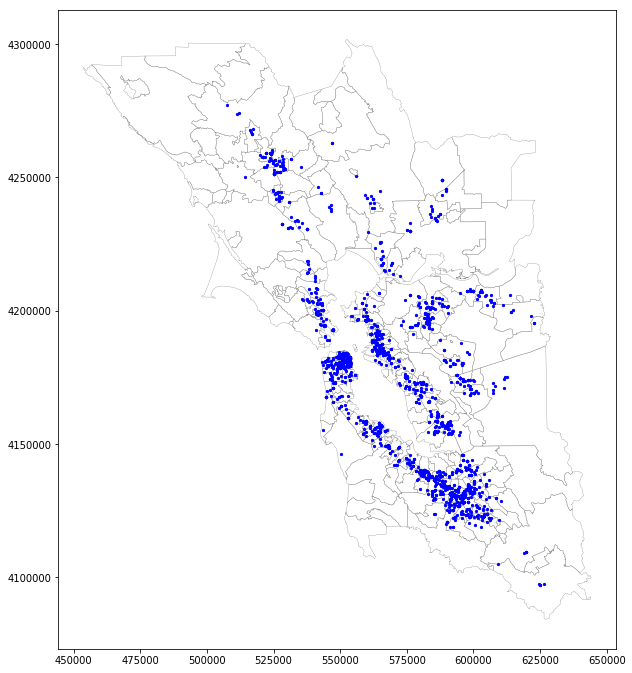

In [53]:
# plot houses on bay area map
base = zips.plot(color='none', edgecolor='gray', linewidth=.3, figsize=(10,20))
house_bay_proj.plot(ax=base, color="b", markersize=5)

In [54]:
house_bay_proj.describe()

,pid,rent,bedroom,ft2,longitude,latitude,index_right,ZIPCODE_ID,AREA,POPULATION,...,FEMALE_WID,FEMALE_DIV,LANG_ENGLI,LANG_GERMA,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI
count,1.826000e+03,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,...,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,6.737977e+09,3165.356517,1.973713,1134.776013,-122.168639,37.694357,122.553122,123.553122,21.676421,33596.162651,...,1311.310515,1651.113910,22925.578313,228.633078,6.120482,44.509858,38.292442,52.340635,259.496166,193.445783
std,5.859547e+06,1606.994795,0.933028,941.839305,0.255893,0.326365,70.618091,70.618091,52.376438,15537.047011,...,676.321440,769.257347,10679.235620,134.973999,11.883164,42.450424,36.963468,51.594362,301.892437,160.376924
min,6.716913e+09,1075.000000,1.000000,80.000000,-122.915128,37.012183,1.000000,2.000000,0.074413,750.000000,...,11.000000,29.000000,478.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.736513e+09,2300.250000,1.000000,750.000000,-122.391187,37.390764,62.000000,63.000000,3.596290,23285.000000,...,862.000000,1118.000000,15904.750000,125.000000,0.000000,10.000000,13.000000,15.000000,51.000000,87.000000
50%,6.741386e+09,2795.000000,2.000000,976.500000,-122.095030,37.707435,102.000000,103.000000,6.983250,31935.000000,...,1271.000000,1662.000000,22888.000000,218.000000,0.000000,31.000000,28.000000,40.000000,138.000000,147.000000
75%,6.741507e+09,3537.750000,2.000000,1224.250000,-121.966268,37.881528,180.000000,181.000000,17.653500,46292.000000,...,1667.000000,2153.000000,29772.000000,326.000000,8.000000,68.750000,53.000000,76.000000,344.000000,266.000000
max,6.741646e+09,25995.000000,7.000000,26000.000000,-121.577300,38.642435,265.000000,266.000000,465.220000,76117.000000,...,4080.000000,4026.000000,54830.000000,607.000000,62.000000,193.000000,205.000000,437.000000,1621.000000,1167.000000


# Clean Data

In [ ]:
# Part 1-1

# get data from census API
endpoint_url = "https://api.census.gov/data/2015/acs5?" \
"get=NAME,B01003_001E,B07013_002E,B07013_003E&" \
"for=tract:*&in=state:06&in=county:*&key=9e518d813c34cefe46bf0317ca1b54e57d30219a"
census_list = json.loads(requests.get(endpoint_url).text)

# convert python list to pandas DF
census_df = pd.DataFrame(census_list[1:], columns=["Tract", "TotalPop","TotalOwn","TotalRent","state", "county", "tract"])

# convert from str to int except tract column
for col in list(census_df.columns)[1:]:
    census_df[col] = census_df[col].astype(int)

census_df.head()

In [ ]:
census_tract_df = census_df['Tract'].str.split(',', expand=True)
census_tract_df.columns = ["Census Tract","CountyName","StateName"]
census_df = pd.concat([census_df,census_tract_df["CountyName"]],axis=1)
census_df.head()

In [ ]:
def zero_padding_four(num):
    return '{0:03d}'.format(num)
    

census_df["county"] = census_df["county"].apply(zero_padding_four)

def zero_padding_two(num):
    return '{0:02d}'.format(num)

census_df["state"] = census_df["state"].apply(zero_padding_two)

In [ ]:
census_df["FIRST_FIPS"] = census_df["state"] + census_df["county"]
census_df.head()

In [ ]:
fips_county = census_df[["FIRST_FIPS","CountyName"]]
fips_county.head()

In [ ]:
house_bay_geodf = pd.merge(house_bay_geodf, fips_county, how="left")
house_bay_geodf.head()

In [ ]:
house_bay_geodf["CountyName"].value_counts().plot(kind="bar")

In [ ]:
pop_county = census_df[["CountyName","TotalPop"]].groupby(by="CountyName")
pop_county_sum = pop_county.sum().reset_index()
pop_county_sum.head()

In [ ]:
house_county_sum = pd.DataFrame(house_bay_geodf["CountyName"].value_counts()).reset_index()
house_county_sum.columns = ["CountyName", "No. of rentals"]
house_county_sum.head()

In [ ]:
house_pop_county = pd.merge(house_county_sum, pop_county_sum, how="left")
house_pop_county

In [ ]:
sns.jointplot("TotalPop", "No. of rentals", data=house_pop_county)

In [ ]:
sf1store = pd.HDFStore('data/bay_sf1_small.h5')
sf1 = sf1store['sf1_extract']
sf1 = sf1[sf1['P0030001']>0]
sf1.head()

In [ ]:
house_census_geodf = pd.merge(house_bay_geodf, sf1, left_on="STFID", right_on="blockfips")
house_census_geodf

In [ ]:
house_bay_geodf.shape

In [ ]:
?pd.merge